# Chargement des librairies et montage du Google Drive

In [2]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import Audio
import seaborn as sns
import pickle
import librosa
from librosa import stft
import glob
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Classe audioFile

La classe audioFile structure nos méthodes de traitement d'un fichier audio: écouter, récupérer et visualiser un spectrogramme ou un logMel spectrogramme, ajouter un bruit blanc, etc.

## Construction

In [3]:
class audioFile : 

  def __init__(self, filePath, normalize = True):

    # filePath localise le fichier source
    # le constructeur récupère le fichier à l'adresse indiquée et lui associe:
    # - son signal audio et sa fréquence d'échantillonnage, par librosa.load
    # - la longueur du signal audio, exprimée en nombre d'échantillons 
    # - la durée du signal audio, exprimée en s
    # on peut choisir de normaliser (moyenne, écart-type) le signal audio

    self.audioSignal, self.samplingFrequency = librosa.load(path = filePath, sr = None)
    
    if normalize:
      average = np.mean(self.audioSignal)
      std_deviation = np.std(self.audioSignal)
      self.audioSignal = (self.audioSignal - average)/std_deviation
    
    self.length = len(self.audioSignal)
    self.duration = len(self.audioSignal)/self.samplingFrequency
    self.filePath = filePath

  def spectrogram(self, dt=0.025, k_temp = 1, k_freq = 1):

    # spectrogram renvoie une transformée de Fourier discrète du signal audio
    # n_fft et hop_length sont par défaut égaux au nombre de points du signal sur 25ms
    # soit par exemple: 0,025s * 8000Hz = 200 points
    # k_temp et k_freq permettent de moduler hop_length (résolution temporelle) et n_fft (résolution fréquentielle)
    # un spectrogram est de dimension: (n_fft//2 + 1, length//hop_length + 1)

    spectrogram = np.abs(stft(self.audioSignal, n_fft = int(self.samplingFrequency * dt/k_freq), 
                       hop_length = int(self.samplingFrequency * dt * k_temp)))

    return spectrogram
  

  def logMelSpectrogram(self, dt = 0.025, k_temp = 1, k_freq = 1):

    # logMelSpectrogram renvoie le logMelSpectrogram du signal, à partir de spectrogram et de librosa.filters.mel
    # n_fft et hop_length sont par défaut égaux au nombre de points du signal sur 25ms
    # soit par exemple: 0,025s * 8000Hz = 200 points
    # k_temp et k_freq permettent de moduler hop_length (résolution temporelle) et n_fft (résolution fréquentielle)
    # un logMelSpectrogram est de dimension: (length//hop_length + 1, n_fft//2 + 1)

    # Filtre de MEL
    
    spectrogram = self.spectrogram(dt, k_temp, k_freq)
    num_spectrograms_bins = spectrogram.T.shape[-1] #soit n_fft//2 +1 = (samplingFrequency*dt/k_freq)//2 + 1
    
    linear_to_mel_weight_matrix = librosa.filters.mel(
        sr = self.samplingFrequency,
        #n_fft=int(dt*self.samplingFrequency) + 1,
        n_fft=int(dt*self.samplingFrequency/k_freq) + 1,
        n_mels=num_spectrograms_bins).T

    # application du filtre au spectrogramme

    mel_spectrogram = np.tensordot(
        spectrogram.T,
        linear_to_mel_weight_matrix,
        1)

    return np.log(mel_spectrogram + 1e-6)
    
  def plotSpectrogram(self, dt=0.025, k_temp=1, k_freq=1):

    # plotSpectrogram renvoie la représentation classique (heatmap) d'un spectrogramme
    
    spectrogram = self.spectrogram(dt, k_temp, k_freq)

    plt.figure(figsize = (15,8))

    sns.heatmap(np.rot90(spectrogram.T), cmap='inferno', vmin=0, vmax=np.max(spectrogram)/3)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*self.length/self.samplingFrequency/loc.max(), 2)
    plt.xticks(loc, l)
    loc, labels = plt.yticks()
    l = np.array(loc[::-1]*self.samplingFrequency/2/loc.max(), dtype=int)
    plt.yticks(loc, l)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

  def plotLogMelSpectrogram(self, dt=0.025, start = 0, stop = 1, k_temp=1, k_freq=1):

    # plotLogMelSpectrogram renvoie la représentation classique (heatmap) d'un logMelSpectrogram
    # start et stop permettent de zoomer sur l'axe temporel, ils sont définis entre 0 et 1, 
    # relativement à la durée totale du logMelSpectrogram

    logMelSpectrogram = self.logMelSpectrogram(dt, k_temp, k_freq)
    startPoint = int(start*len(logMelSpectrogram))
    stopPoint = int(stop*len(logMelSpectrogram))

    plt.figure(figsize = (15,8))
    sns.heatmap(np.rot90(logMelSpectrogram)[:,startPoint:stopPoint], cmap='inferno', vmin=-6)
    loc, labels = plt.xticks()
    labels = np.round(start*self.duration + (loc - loc.min())*dt,2)
    
    plt.xticks(loc, labels, rotation = 90)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Mel)")
    

  def normalizeLength(self, duration = 1):

    #normalizeLength ajuste la durée du fichier à la durée choisie, 1 sec par défaut
    #et renvoie le fichier ajusté
    
    normalizedSamples = duration * self.samplingFrequency #nombre d'échantillons normalisé

    if self.length >= normalizedSamples: # on coupe le fichier au nombre d'échantillons choisi
      self.audioSignal = self.audioSignal[:int(normalizedSamples)]
      self.length = normalizedSamples
    else: # on comble l'écart au nombre d'échantillons choisi avec des zéros (du silence)
      self.audioSignal = np.concatenate([self.audioSignal, np.zeros(int(normalizedSamples - self.length))])
      self.length = normalizedSamples
      self.duration = len(self.audioSignal)/self.samplingFrequency
    return self # renvoie le fichier avec signal et durée ajustés

  def addWhiteNoise(self, amplitude = 0.005, factor = 1):

    # ajoute un bruit blanc d'amplitude comprise, par défaut, entre 0 et 1% de celle du signal par défaut

    #amplitude = factor * (amplitude + (.01*random.random() - .005))
    amplitude = factor * amplitude

    whiteNoise = np.random.normal(0, amplitude*np.max(np.abs(self.audioSignal)), self.length)
    self.audioSignal = np.array(self.audioSignal + whiteNoise)

    return self #renvoie un audioFile "bruité"

  def play(self):

    # permet d'écouter le fichier
    Audio(data = self.audioSignal, rate = self.samplingFrequency, autoplay = True)

  def record(self, sec=3):

    # pour s'enregistrer

    display(Javascript(RECORD)) #Javascript à définir!
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    audio = AudioSegment.from_file(BytesIO(b))
      
    with open(self.filePath,'wb') as f:
      f.write(b)

    return self #renvoie un audioFile enregistré sous filePath

  def subsample(self, factor):

    # pour obtenir un fichier ajusté à une fréquence cible plus faible

    signal = [self.audioSignal[factor*k] for k in np.arange(0, int(self.length/factor))]
    
    self.audioSignal = np.array(signal) #on remplace le signal original
    self.length = len(signal)
    self.samplingFrequency = int(self.samplingFrequency/factor)
    
    return self # renvoie un audioFile rééchantillonné


## Visualisations et tests

Ecoutons des enregistrements puis visualisons des logMelSpectrogram dans les 3 cas suivants:
- fichier brut
- fichier après normalisation du signal audio
- fichier normalisé bruité

In [71]:
rootPath = '/content/drive/My Drive/samples/'
sample1 = rootPath + 'sample1.flac'
sample2 = rootPath + 'sample2.flac'
sample3 = rootPath + 'sample3.flac'
sample4 = rootPath + 'sample4.flac'
sample5 = rootPath + 'sample5.flac'

k = 5
audioFile1 = audioFile(sample1, normalize = False)
audioFile2 = audioFile(sample1, normalize = True)
audioFile31 = audioFile(sample1, normalize = True).addWhiteNoise(factor = k)
audioFile32 = audioFile(sample2, normalize = True).addWhiteNoise(factor = k)
audioFile33 = audioFile(sample3, normalize = True).addWhiteNoise(factor = k)
audioFile34 = audioFile(sample4, normalize = True).addWhiteNoise(factor = k)
audioFile35 = audioFile(sample5, normalize = True).addWhiteNoise(factor = k)

In [6]:
Audio(data = audioFile1.audioSignal, rate = audioFile1.samplingFrequency)

In [7]:
Audio(data = audioFile2.audioSignal, rate = audioFile2.samplingFrequency)

In [72]:
Audio(data = audioFile35.audioSignal, rate = audioFile35.samplingFrequency)

La normalisation du signal audio ne produit aucun effet perceptible.
Le bruit blanc est quant à lui bien audible, mais le texte reste largement compréhensible, jusqu'à un facteur 5 appliqué à notre fonction.

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


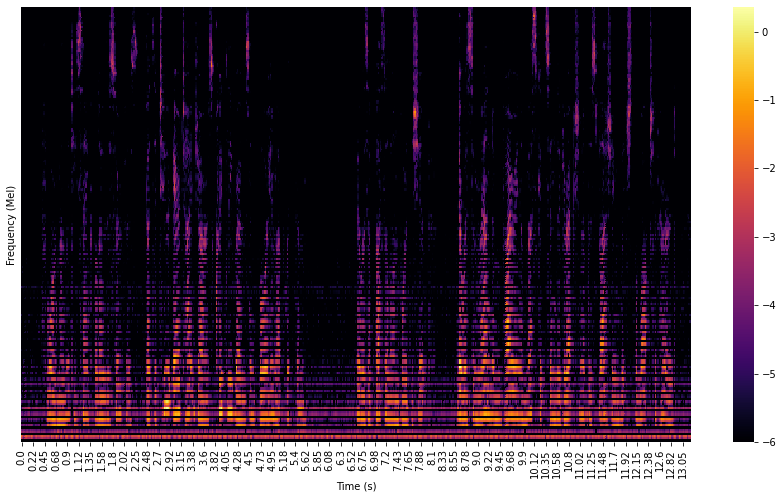

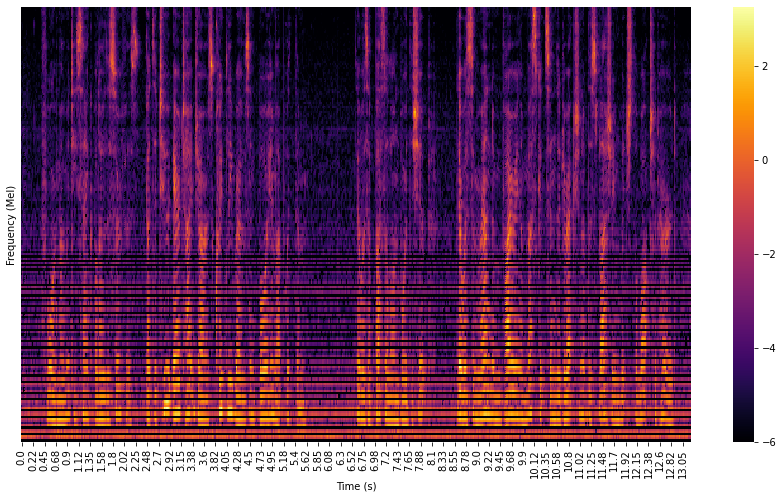

In [9]:
audioFile1.plotLogMelSpectrogram()
audioFile2.plotLogMelSpectrogram()

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


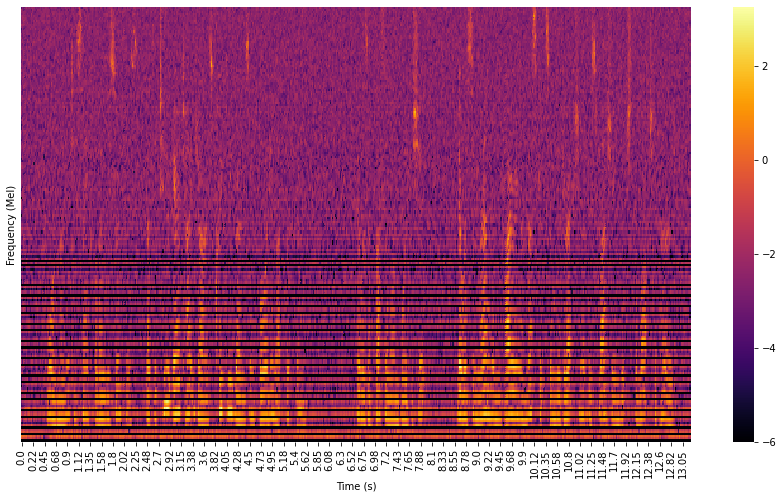

In [73]:
audioFile31.plotLogMelSpectrogram()

On semble lire des bandes de fréquence vides (confirmé par le warning), ce qui suggère une résolution fréquentielle inutilement élevée. Essayons donc de la diminuer.

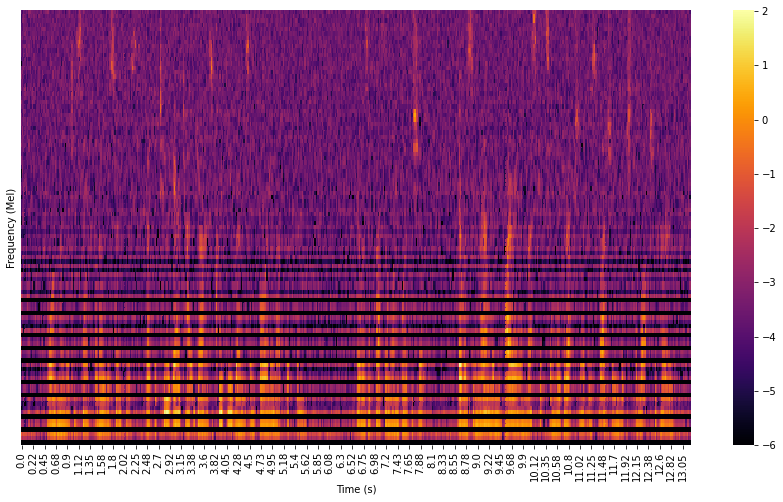

In [74]:
audioFile3.plotLogMelSpectrogram(k_freq = 2)

Certaines bandes restent visiblement très peu utilisées. 
Difficile de dire si un tel traitement est préférable, ou non, au précédent, pour optimiser l'apprentissage de notre modèle.

# Dataset LibriSpeech

## Rassemblement des meta-données: adresses et caractéristiques des fichiers audio

In [12]:
rootPathTrain = '/content/drive/My Drive/LibriSpeech/train/'
rootPathTest = '/content/drive/My Drive/LibriSpeech/test/'


In [13]:
# on rassemble tous les .txt descriptifs des data train et test

list_txtTrainFiles = glob.glob(rootPathTrain  + '*/*/*.txt')
list_txtTestFiles = glob.glob(rootPathTest + '*/*/*.txt')

# et on sauve les deux listes 

with open ('/content/drive/My Drive/LibriSpeech/metadata/list_txtTrainFiles', 'wb') as f:
  pickle.dump(list_txtTrainFiles, f)
with open ('/content/drive/My Drive/LibriSpeech/metadata/list_txtTestFiles', 'wb') as f:
  pickle.dump(list_txtTestFiles, f)


KeyboardInterrupt: ignored

In [ ]:
# on rassemble dans deux dataframes, les données relatives aux fichiers audio, et leurs étiquettes

df_train = pd.concat([pd.read_csv(fileName, header = None) for fileName in list_txtTrainFiles], axis = 0) #concatène tous les .txt dans un dataframe
df_train['rootPath'] = rootPathTrain
df_train['fileDirectory'] = df_train[0].apply(lambda x: x.split('-')[0] + '/' + x.split('-')[1] +'/') #isole le répertoire du fichier
df_train['fileName'] = df_train[0].apply(lambda x: x.split(' ')[0] + '.flac') #isole le nom du fichier
df_train['filePath'] = df_train['rootPath'] + df_train["fileDirectory"] + df_train["fileName"]
df_train['sampling frequency'] = df_train['filePath'].apply(lambda x: audioFile(x).samplingFrequency)
df_train['audio duration'] = df_train['filePath'].apply(lambda x: audioFile(x).duration) 
df_train['label'] = df_train[0].apply(lambda x: x.split(x.split(' ')[0])[1]) #label = tous les caractères après le premier espace
df_train['label length'] = df_train['label'].apply(lambda x: len(x))
df_train = df_train.drop(df_train.columns[0], axis = 1)

df_test = pd.concat([pd.read_csv(fileName, header = None) for fileName in list_txtTestFiles], axis = 0) 
df_test['rootPath'] = rootPathTest 
df_test['fileDirectory'] = df_test[0].apply(lambda x: x.split('-')[0] + '/' + x.split('-')[1] +'/')
df_test['fileName'] = df_test[0].apply(lambda x: x.split(' ')[0] + '.flac')
df_test['filePath'] = df_test['rootPath'] + df_test["fileDirectory"] + df_test["fileName"]
df_test['sampling frequency'] = df_test['filePath'].apply(lambda x: audioFile(x).samplingFrequency)
df_test['audio duration'] = df_test['filePath'].apply(lambda x: audioFile(x).duration) 
df_test['label'] = df_test[0].apply(lambda x: x.split(x.split(' ')[0])[1])
df_test['label length'] = df_test['label'].apply(lambda x: len(x))
df_test = df_test.drop(df_test.columns[0], axis = 1)

# et on sauve les deux dataframes

with open ('/content/drive/My Drive/LibriSpeech/metadata/train_metadata_full', 'wb') as f:
  pickle.dump(df_train, f)
with open ('/content/drive/My Drive/LibriSpeech/metadata/test_metadata_full', 'wb') as f:
  pickle.dump(df_test, f)


## Exploration

In [75]:
rootPathTrain = '/content/drive/My Drive/LibriSpeech/train/'
rootPathTest = '/content/drive/My Drive/LibriSpeech/test/'


In [ ]:
with open ('/content/drive/My Drive/LibriSpeech/metadata/train_metadata_full', 'rb') as f:
  df_train = pickle.load(f)
with open ('/content/drive/My Drive/LibriSpeech/metadata/test_metadata_full', 'rb') as f:
  df_test = pickle.load(f)

In [ ]:
df_full = pd.concat([df_train, df_test], axis = 0)
df_full.info()

In [ ]:
df_full.describe()

In [ ]:
print('Durée audio totale (h): ', df_full['audio duration'].sum()/3600)
print('dont durée audio data train (h): ', df_full[df_full['rootPath'] == rootPathTrain]['audio duration'].sum()/3600)

Les données d'entraînement représentent donc plus de 106h d'audio réparties en 31 289 fichiers d'une durée moyenne de 12s environ, dont près de 101h dans le répertoire train. 
Leur durée est majoritairement comprise entre 10 et 15s, mais il va nous falloir proposer à notre modèle des fichiers de longueur/durée normalisée, en complétant les fichiers "trop courts" par un signal nul (zero padding). 
On peut se demander s'il faut aussi normaliser la longueur des labels (en les prolongeant par des espaces) pour un apprentissage optimal.

Commençons par analyser plus en détail la distribution des durées.

In [ ]:
plt.figure(figsize = (15, 15))

plt.subplot(221)
plt.xlim(left = 0, right = 25)
plt.hist([df_full[df_full['rootPath']==rootPathTrain]['audio duration'], df_full[df_full['rootPath']==rootPathTest]['audio duration']], 
         stacked = True, bins = 50, color = ['orange', 'green'], label = ['train files', 'test files']);
plt.legend(fontsize = 12)
plt.xlabel('audio duration (s)', fontsize = 12)
plt.ylabel('nb files', fontsize = 12)
plt.title('Distribution de la durée des fichiers audio', fontsize = 14)

#colors = {rootPathTrain:'orange', 
#          rootPathTest:'green'}

plt.subplot(222)
plt.scatter(df_full[df_full['rootPath']==rootPathTrain]['audio duration'], df_full[df_full['rootPath']==rootPathTrain]['label length'], c = 'orange', label = 'train files')
plt.scatter(df_full[df_full['rootPath']==rootPathTest]['audio duration'], df_full[df_full['rootPath']==rootPathTest]['label length'], c = 'green', label = 'test files')
plt.legend(fontsize = 12)
plt.xlim(left = 0, right = 35)
plt.ylim(bottom = 0, top = 530)


plt.vlines(x=17, ymin = 0, ymax = 530, colors = 'black')
plt.hlines(y=341, xmin = 0, xmax = 35, colors = 'black')
plt.xlabel('audio duration (s)', fontsize = 12)
plt.ylabel('label length (nb char)', fontsize = 12)
plt.title('Durée des fichiers audio vs longueur des labels', fontsize = 14);

Graphiquement, on lit qu'on peut normaliser à environ 17 sec, en ignorant seulement quelques fichiers plus longs, surtout localisés dans le dataset de test. 
En procédant de la sorte, de nombreux fichiers contiendront un padding de plusieurs secondes. 
Par ailleurs, il est clair que la durée des fichiers et la longueur des labels sont très corrélés, ce qui suggère que les labels ne contiennent pas d'espaces 'inutiles'.

In [ ]:
print('Nb fichiers audio de durée supérieure à 17s: ', df_full[df_full['audio duration'] > 17].shape[0])

En normalisant à 17s, avec un time-step de 25ms et un modèle de stride 2, les sorties de notre modèle seront de longueur 341; notre fonction de perte nous impose de garder des étiquettes plus courtes que cette valeur. Graphiquement, cela semble OK, ce que nous confirmons ci-après: longueur max des étiquettes = 339.

In [ ]:
df_full[df_full['audio duration'] <= 17].describe()

On pourra choisir de normaliser la longueur des étiquettes tout en respectant la longueur maximale de la chaîne de caractère prédite (341). 


In [ ]:
maxLength = 339 
df_full['paddedLabel'] = df_full['label'].apply(lambda label: label + (len(label) < maxLength)*(maxLength - len(label))*' ')
df_full['paddedLength'] = df_full['paddedLabel'].apply(lambda label: len(label))


In [ ]:
df_full.head()

Déterminons maintenant les caractères utilisés dans les labels

In [ ]:
alphabet = []
for label in df_full['label']:
  for character in label:
    if character not in alphabet:
      alphabet.append(character)
alphabet.sort()

print('nombre de caractères utilisés: ', len(alphabet))
print('liste des caractères utilisés: ', alphabet)

Les labels semblent utilisables en l'état : 26 lettres en majuscule, espace et apostrophe, soit 28 caractères en tout, sans accents, tirets, chiffres ni caractères spéciaux.

On redéfinit df_train et df_test après ce complément, en ne gardant que les fichiers de durée inférieure ou égale à la durée de normalisation car les étiquettes des fichiers plus longs seraient fausses.

In [ ]:
df_train = df_full[(df_full['rootPath'] == '/content/drive/My Drive/LibriSpeech/train/') & (df_full['audio duration'] <= 17)]
df_test = df_full[(df_full['rootPath'] == '/content/drive/My Drive/LibriSpeech/test/') & (df_full['audio duration'] <= 17)]


Enfin, on se dote d'un jeu train/test de taille réduite, pour explorer différentes options d'apprentissage.

In [ ]:
df_train_sample = df_train.sample(n = 800, axis = 0)
df_test_sample = df_test.sample(n = 200, axis = 0)

Et on sauve les quatre dataframes.

In [ ]:
with open ('/content/drive/My Drive/LibriSpeech/metadata/train_metadata', 'wb') as f:
  pickle.dump(df_train, f)
with open ('/content/drive/My Drive/LibriSpeech/metadata/test_metadata', 'wb') as f:
  pickle.dump(df_test, f)
with open ('/content/drive/My Drive/LibriSpeech/metadata/train_sample_metadata', 'wb') as f:
  pickle.dump(df_train_sample, f)
with open ('/content/drive/My Drive/LibriSpeech/metadata/test_sample_metadata', 'wb') as f:
  pickle.dump(df_test_sample, f)


# Utilitaires: encodeur/décodeur cible, et décodeur de prédiction

Deux fonctions pour passer d'une chaîne de caractères (label), à un tenseur contenant des entiers (target), et réciproquement

In [4]:
alphabet = [chars for chars in " ABCDEFGHIJKLMNOPQRSTUVWXYZ'"]
character_encoder = keras.layers.StringLookup(vocabulary = alphabet, oov_token = "")
character_decoder = keras.layers.StringLookup(vocabulary = character_encoder.get_vocabulary(), oov_token = "", invert = True)

Et une fonction pour décoder les prédictions du modèle.

In [5]:
def decode_batch_predictions(pred): 

  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  
  # Greedy search : décodage le plus rapide, ne mène pas forcément au texte le plus probable
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
  
  # on itère sur la prédiction et on récupère le texte
  output_text = []
  for result in results:
    result = tf.strings.reduce_join(character_decoder(result)).numpy().decode("utf-8")
    output_text.append(result)
  return output_text


# Générateur

On charge les méta-données du dataset LibriSpeech et on initialise un générateur.
Ces étapes sont regroupées sous une fonction, appelée au début du pre-processing.

In [6]:
def initializeGenerator(paddingLabels = False, paddingLength = 339):

  with open ('/content/drive/My Drive/LibriSpeech/metadata/train_metadata', 'rb') as f:
    df_train = pickle.load(f)
  with open ('/content/drive/My Drive/LibriSpeech/metadata/test_metadata', 'rb') as f:
    df_test = pickle.load(f)
  with open ('/content/drive/My Drive/LibriSpeech/metadata/train_sample_metadata', 'rb') as f:
    df_train_sample = pickle.load(f)
  with open ('/content/drive/My Drive/LibriSpeech/metadata/test_sample_metadata', 'rb') as f:
    df_test_sample = pickle.load(f)

  X_train_path = df_train['filePath'].values
  X_test_path = df_test['filePath'].values
  X_train_sample_path = df_train_sample['filePath'].values
  X_test_sample_path = df_test_sample['filePath'].values

  y_train = df_train['label'].values
  y_test = df_test['label'].values
  y_train_sample = df_train_sample['label'].values
  y_test_sample = df_test_sample['label'].values

  if paddingLabels: #on ajuste la longueur des labels à la valeur indiquée
    df_train['paddedLabel'] = df_train['label'] \
                              .apply(lambda label: label + (len(label) < paddingLength)*(paddingLength - len(label))*' ')
    df_train_sample['paddedLabel'] = df_train_sample['label'] \
                              .apply(lambda label: label + (len(label) < paddingLength)*(paddingLength - len(label))*' ')
    df_test['paddedLabel'] = df_test['label'] \
                              .apply(lambda label: label + (len(label) < paddingLength)*(paddingLength - len(label))*' ')
    df_test_sample['paddedLabel'] = df_test_sample['label'] \
                              .apply(lambda label: label + (len(label) < paddingLength)*(paddingLength - len(label))*' ')
    y_train = df_train['paddedLabel'].values
    y_test = df_test['paddedLabel'].values
    y_train_sample = df_train_sample['paddedLabel'].values
    y_test_sample = df_test_sample['paddedLabel'].values

  train_dataset = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
  test_dataset = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))
  
  train_sample_dataset = tf.data.Dataset.from_tensor_slices((X_train_sample_path, y_train_sample))
  test_sample_dataset = tf.data.Dataset.from_tensor_slices((X_test_sample_path, y_test_sample))
  
  return train_dataset, test_dataset, train_sample_dataset, test_sample_dataset



# Fonction de perte: CTC loss

In [7]:
def CTC_loss(y_test, y_pred):
    
  batch_len = tf.cast(tf.shape(y_test)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_test)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_test, y_pred, input_length, label_length)
  
  return loss

# Modèle: constructeur

Notre modèle est dérivé de DeepSpeech 2

In [8]:
def build_model(input_dim1, input_dim2, output_dim, name,
                drop_out_rate = 0.5,
                kernel_size_x1 = 11, kernel_size_y1 = 41,
                kernel_size_x2 = 11, kernel_size_y2 = 21,
                rnn_layers = 5, 
                rnn_units = 512):
  # constructeur de notre modèle

  # Input
  input_spectrogram = layers.Input((input_dim1, input_dim2), name="input")
    
  #Ajouter une dimension pour utiliser des CNN à deux dimensions
  x = layers.Reshape((input_dim1, input_dim2, 1), name="expand_dim")(input_spectrogram)
    
  # Convolution layer 1
    
  x = layers.Conv2D(
      filters=32,
      kernel_size=[kernel_size_x1, kernel_size_y1],
      strides=[2, 2],
      padding="same",
      use_bias=False,
      name="conv_1",
    )(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)
    
  # Convolution layer 2
  x = layers.Conv2D(
      filters=32,
      kernel_size=[kernel_size_x2, kernel_size_y2],
      strides=[1, 2],
      padding="same",
      use_bias=False,
      name="conv_2",
    )(x)
  
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)
    
  # Mise en forme pour alimenter les RNN layers
  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    
  # RNN layers
  for i in range(1, rnn_layers + 1):
      recurrent = layers.GRU(
          units=rnn_units,
          activation="tanh",
          recurrent_activation="sigmoid",
          use_bias=True,
          return_sequences=True,
          reset_after=True,
          name=f"gru_{i}",
        )
      x = layers.Bidirectional(
          recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
      if i < rnn_layers:
          x = layers.Dropout(rate=drop_out_rate)(x)
    
    # Dense layer
  x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
  x = layers.ReLU(name="dense_1_relu")(x)
  x = layers.Dropout(rate=drop_out_rate)(x)
    
    # Classification layer
  output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    
    # Construction du modèle
  model = keras.Model(input_spectrogram, output, name= name)
    
    # Optimizer
  opt = keras.optimizers.Adam(learning_rate=1e-4)
    
  
  #compilation avec "notre" ctc_loss
  model.compile(optimizer = opt, loss = CTC_loss)

  return model


# Apprentissage

On définit le répertoire de stockage de nos données d'entraînement

In [8]:
savePath = '/content/drive/My Drive/spych/v9/'

### Pre-processing

In [9]:
preprocessing = {
    'normalizeSignal': True,
    'noiseFactor': 5, # 0 pour ne pas bruiter
    'normalizedLength': 17,
    'timeStep': 0.025,
    'paddingLabels': False,
    'paddingLength': 339,
    'k_temp': 0.8,
    'k_freq': 1.5}

# respecter: paddingLength < normalizedLength/timeStep/2 + 1
# division par 2 avec des couches de convolution utilisant un stride horizontal de 2
# Si on souhaite ajuster normalizedLength, il faut redéfinir les jeux train/test 

On initialise notre générateur

In [10]:
train_dataset, test_dataset, train_sample_dataset, test_sample_dataset = initializeGenerator(
    preprocessing['paddingLabels'], preprocessing['paddingLength'])

On définit les étapes de pre-processing/augmentation des données, en fonction des paramètres retenus.

In [11]:
def loadSpectrogram(filePath):

  logMelSpectrogram = audioFile(filePath.numpy(), normalize = preprocessing['normalizeSignal']) \
  .normalizeLength(preprocessing['normalizedLength']) \
  .addWhiteNoise(factor = preprocessing['noiseFactor']) \
  .logMelSpectrogram(dt = preprocessing['timeStep'], k_temp = preprocessing['k_temp'], k_freq = preprocessing['k_freq'])

  return logMelSpectrogram

def loadCleanSpectrogram(filePath):

  logMelSpectrogram = audioFile(filePath.numpy(), normalize = preprocessing['normalizeSignal']) \
  .normalizeLength(preprocessing['normalizedLength']) \
  .logMelSpectrogram(dt = preprocessing['timeStep'], k_temp = preprocessing['k_temp'], k_freq = preprocessing['k_freq'])

  return logMelSpectrogram


def codeLabel(label):
  label = tf.strings.unicode_split(label, input_encoding="UTF-8")  
  return character_encoder(label)


Ce pre-processing est appliqué à train_dataset, test_dataset, ainsi qu'à train_sample_dataset et test_sample_dataset.

In [12]:
train_dataset = train_dataset.map(lambda x, y: 
                                  [tf.py_function(loadSpectrogram, [x], [tf.float64]), 
                                   tf.py_function(codeLabel, [y], [tf.int64])], 
                                  num_parallel_calls=-1)
test_dataset = test_dataset.map(lambda x, y: 
                                  [tf.py_function(loadCleanSpectrogram, [x], [tf.float64]), 
                                   tf.py_function(codeLabel, [y], [tf.int64])], 
                                  num_parallel_calls=-1)

In [13]:
train_sample_dataset = train_sample_dataset.map(lambda x, y: 
                                  [tf.py_function(loadSpectrogram, [x], [tf.float64]), 
                                   tf.py_function(codeLabel, [y], [tf.int64])], 
                                  num_parallel_calls=-1)
test_sample_dataset = test_sample_dataset.map(lambda x, y: 
                                  [tf.py_function(loadCleanSpectrogram, [x], [tf.float64]), 
                                   tf.py_function(codeLabel, [y], [tf.int64])], 
                                  num_parallel_calls=-1)

### Callbacks

In [14]:
predictionHistory = []

In [15]:
# on enregistre le modèle à chaque epoch

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = savePath, verbose=1)

# sauve la liste des prédictions sur sample_test, le modèle et son historique d'apprentissage, à chaque epoch

class save_callback(keras.callbacks.Callback):

  def __init__(self, model, dataset, savePath, predictionHistory):
    super().__init__()
    self.dataset = dataset  
    self.model = model
    self.predictionHistory = predictionHistory
    self.savePath = savePath

  def on_epoch_end(self, epoch:int, logs = None):
    
    for batch in self.dataset:     
      X, y = batch
      predictions = decode_batch_predictions(model.predict(X, verbose = 0))
      self.predictionHistory.append(predictions)
      
    with open(self.savePath + 'predictionHistory', 'wb') as f:
      pickle.dump(predictionHistory, f)
    
     

### Instanciation d'un modèle

In [16]:
model_settings = {
    'name': 'spych_v8',
    'input_dim1': int(preprocessing['normalizedLength']/preprocessing['timeStep']/preprocessing['k_temp'] + 1), #dimension temporelle
    'input_dim2': int(16000*preprocessing['timeStep']/preprocessing['k_freq']//2 +1), #dimension fréquentielle, fréquence d'échantillonnage 16kHz
    'output_dim': character_decoder.vocabulary_size(),
    'kernel_size_x1': 11,
    'kernel_size_y1': 41,
    'kernel_size_x2': 11,
    'kernel_size_y2': 21,
    'drop_out_rate': 0.2,
    'rnn_layers': 5,
    'rnn_units' : 512
    }

In [17]:
model = build_model(
    name = model_settings['name'],
    input_dim1 = model_settings['input_dim1'],
    input_dim2 = model_settings['input_dim2'],
    output_dim = model_settings['output_dim'],
    kernel_size_x1 = model_settings['kernel_size_x1'],
    kernel_size_y1 = model_settings['kernel_size_y1'],
    kernel_size_x2 = model_settings['kernel_size_x2'],
    kernel_size_y2 = model_settings['kernel_size_y2'],
    drop_out_rate = model_settings['drop_out_rate'],
    rnn_layers = model_settings['rnn_layers'],
    rnn_units = model_settings['rnn_units'])

model.summary()


Model: "spych_v8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 851, 134)]        0         
                                                                 
 expand_dim (Reshape)        (None, 851, 134, 1)       0         
                                                                 
 conv_1 (Conv2D)             (None, 426, 67, 32)       14432     
                                                                 
 conv_1_bn (BatchNormalizati  (None, 426, 67, 32)      128       
 on)                                                             
                                                                 
 conv_1_relu (ReLU)          (None, 426, 67, 32)       0         
                                                                 
 conv_2 (Conv2D)             (None, 426, 34, 32)       236544    
                                                          

## Entraînement

In [18]:
predictionHistory = []

callbacks_list = [checkpoint_callback, 
                  save_callback(model = model, savePath = savePath, dataset = test_sample_dataset,
                                predictionHistory = predictionHistory)] 

training_settings = {
    'epochs' : 12,
    'batch_size': 32
    }

In [19]:
history = model.fit(train_sample_dataset, 
                    validation_data = test_sample_dataset, 
                    epochs = training_settings['epochs'], 
                    batch_size = training_settings['batch_size'], 
                    callbacks = callbacks_list)

with open(savePath + 'history', 'wb') as f:
  pickle.dump(history, f)

Epoch 1/12


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - ETA: 0s - loss: 554.3533
Epoch 1: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 343s 393ms/step - loss: 554.3533 - val_loss: 383.8630
Epoch 2/12
800/800 [==============================] - ETA: 0s - loss: 531.8304
Epoch 2: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 315s 394ms/step - loss: 531.8304 - val_loss: 392.5766
Epoch 3/12
800/800 [==============================] - ETA: 0s - loss: 500.2839
Epoch 3: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 316s 395ms/step - loss: 500.2839 - val_loss: 276.7094
Epoch 4/12
800/800 [==============================] - ETA: 0s - loss: 466.5419
Epoch 4: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 317s 396ms/step - loss: 466.5419 - val_loss: 266.0943
Epoch 5/12
800/800 [==============================] - ETA: 0s - loss: 430.3299
Epoch 5: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 317s 396ms/step - loss: 430.3299 - val_loss: 254.8177
Epoch 6/12
800/800 [==============================] - ETA: 0s - loss: 400.3306
Epoch 6: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 316s 395ms/step - loss: 400.3306 - val_loss: 235.0398
Epoch 7/12
800/800 [==============================] - ETA: 0s - loss: 375.1371
Epoch 7: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 315s 394ms/step - loss: 375.1371 - val_loss: 221.7812
Epoch 8/12
800/800 [==============================] - ETA: 0s - loss: 354.2356
Epoch 8: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 315s 394ms/step - loss: 354.2356 - val_loss: 211.7964
Epoch 9/12
800/800 [==============================] - ETA: 0s - loss: 334.6811
Epoch 9: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 316s 395ms/step - loss: 334.6811 - val_loss: 205.2991
Epoch 10/12
800/800 [==============================] - ETA: 0s - loss: 316.9770
Epoch 10: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 311s 388ms/step - loss: 316.9770 - val_loss: 202.2576
Epoch 11/12
800/800 [==============================] - ETA: 0s - loss: 299.5701
Epoch 11: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 316s 394ms/step - loss: 299.5701 - val_loss: 198.0341
Epoch 12/12
800/800 [==============================] - ETA: 0s - loss: 282.0528
Epoch 12: saving model to /content/drive/My Drive/spych/v9/


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


800/800 [==============================] - 314s 393ms/step - loss: 282.0528 - val_loss: 197.4216


# Résultats

In [9]:
# On récupère les étiquettes
with open ('/content/drive/My Drive/LibriSpeech/metadata/test_sample_metadata', 'rb') as f:
    df_test_sample = pickle.load(f)

y_test_sample = df_test_sample['label'].values

## Analyse d'une configuration

In [20]:
savePath = '/content/drive/My Drive/spych/v8/'

Chargement de l'historique d'apprentissage d'un modèle

In [21]:
custom_objects = {"CTC_loss": CTC_loss}
with keras.utils.custom_object_scope(custom_objects):
  with open(savePath + 'history', 'rb') as f:
      history = pickle.load(f)
with open(savePath + 'predictionHistory', 'rb') as f:
  listPredictions = pickle.load(f)


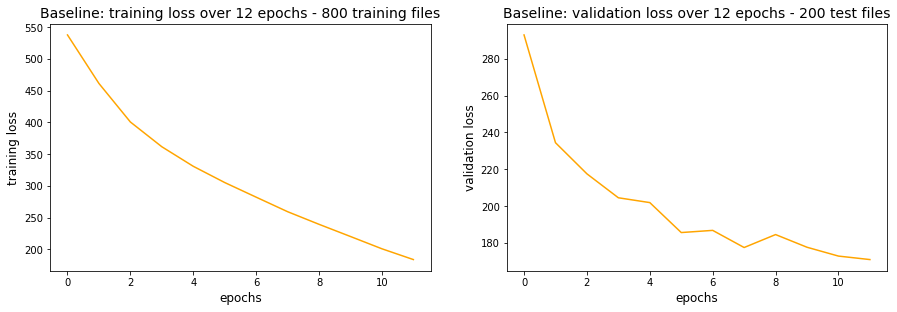

In [22]:
plt.figure(figsize = (15, 10))

plt.subplot(221)
plt.plot(history.history['loss'], color = 'orange')
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('training loss', fontsize = 12)
plt.title('Baseline: training loss over 12 epochs - 800 training files', fontsize = 14);

plt.subplot(222)
plt.plot(history.history['val_loss'], color = 'orange')
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('validation loss', fontsize = 12)
plt.title('Baseline: validation loss over 12 epochs - 200 test files', fontsize = 14);

Observation des prédictions comparées aux étiquettes

In [23]:
k = 140
epochs = 12
test_size = 200

target = y_test_sample[k]

print('TARGET:')
print('longueur:', len(target), ' étiquette:', target)

print('\nPREDICTIONS')

for epoch in range(epochs):
  prediction = listPredictions[k + test_size*epoch][0]
  print('EPOCH:', epoch+1, 'longueur:', len(prediction), ' prédiction:', prediction)



TARGET:
longueur: 59  étiquette:  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING

PREDICTIONS
EPOCH: 1 longueur: 9  prédiction:    RSS  S
EPOCH: 2 longueur: 43  prédiction:  HT LY O ND RTERINS S TER IN IEND CO LS MOI
EPOCH: 3 longueur: 47  prédiction:  IT WLE A IN PRTERIN SESTER IEN E TO WAS MNOFEN
EPOCH: 4 longueur: 49  prédiction:  IT WLI HE AN PROTER IN SISPER IN LE TO AS NO HEN
EPOCH: 5 longueur: 51  prédiction:  IT WL THE EN PROTHER IN SISPER INKEE TOWAS NO HEIN
EPOCH: 6 longueur: 49  prédiction:  I WL HAD EN PROTER INSISTER IN KE TOE AS NO HEIN
EPOCH: 7 longueur: 52  prédiction:  IT WL HAD EN PROTHER IN SESPER IN BEE GE WAS NOTHIN
EPOCH: 8 longueur: 50  prédiction:  IT WL HADEN PROHER INSISTER IN KEE GER AS NOFHING
EPOCH: 9 longueur: 54  prédiction:  ITF L HAD EN PROTHER INSISSFERT IN EE TER WAS NOTHING
EPOCH: 10 longueur: 50  prédiction:  IT WL HAD EN PROTHER INSISTER IN EE HER AS NOHING
EPOCH: 11 longueur: 50  prédiction:  ITFWL HAD BEN BROHER IN SISTER INBEE GI WAS

In [28]:
k = int(200*random.random())
epochs = 12
test_size = 200

target = y_test_sample[k]

print('TARGET')
print('longueur:', len(target), ' étiquette:', target)

print('\nPREDICTIONS')

for epoch in range(epochs):
  prediction = listPredictions[k + test_size*epoch][0]
  print('EPOCH:', epoch+1, 'longueur:', len(prediction), ' prédiction:', prediction)

TARGET
longueur: 43  étiquette:  I WAS CHILLED TO THE BONE WET TIRED HUNGRY

PREDICTIONS
EPOCH: 1 longueur: 6  prédiction:  S    
EPOCH: 2 longueur: 26  prédiction:  ND TS SO TO TE BO AT R IR
EPOCH: 3 longueur: 33  prédiction:  ND WIS TOL O TE BON WLET TIER IR
EPOCH: 4 longueur: 31  prédiction:  IN WAS TOL O TH O LET PIER IRE
EPOCH: 5 longueur: 38  prédiction:  IN WAS TOL O THE ON WHIT PLIERED I RE
EPOCH: 6 longueur: 41  prédiction:  IN WAS TRILE TO THE BON WHET TLIERED IRE
EPOCH: 7 longueur: 39  prédiction:  IN WAS TROLE O THE ON WHET PIERED INRE
EPOCH: 8 longueur: 36  prédiction:  I WAS TRIL O THE BOON WET TIRED IRE
EPOCH: 9 longueur: 38  prédiction:  IN WAS TRIL O THE OON WHET TIRED INRE
EPOCH: 10 longueur: 38  prédiction:  IN WAS TRINE O THE ON LET TIRED UNGRE
EPOCH: 11 longueur: 37  prédiction:  I WAS SRILT TO THE ON WET TIRED UNRE
EPOCH: 12 longueur: 39  prédiction:  I WAS SRILKT O THE OON WET TIRED UNRET


## Comparaison de configurations

In [10]:
savePath0 = '/content/drive/My Drive/spych/v0/'
savePath1 = '/content/drive/My Drive/spych/v1/'
savePath2 = '/content/drive/My Drive/spych/v2/'
savePath3 = '/content/drive/My Drive/spych/v3/'
savePath4 = '/content/drive/My Drive/spych/v4/'
savePath5 = '/content/drive/My Drive/spych/v5/'
savePath6 = '/content/drive/My Drive/spych/v6/'
savePath7 = '/content/drive/My Drive/spych/v7/'
savePath8 = '/content/drive/My Drive/spych/v8/'
savePath9 = '/content/drive/My Drive/spych/v9/'

Chargement des historiques d'apprentissage

In [11]:
custom_objects = {"CTC_loss": CTC_loss}
with keras.utils.custom_object_scope(custom_objects):
  with open(savePath0 + 'history', 'rb') as f:
      history0 = pickle.load(f)
  #with open(savePath1 + 'history', 'rb') as f:
  #    history1 = pickle.load(f)
  #with open(savePath2 + 'history', 'rb') as f:
  #    history2 = pickle.load(f)
  #with open(savePath3 + 'history', 'rb') as f:
  #    history3 = pickle.load(f)
  with open(savePath4 + 'history', 'rb') as f:
      history4 = pickle.load(f)
  #with open(savePath5 + 'history', 'rb') as f:
  #    history5 = pickle.load(f)
  #with open(savePath6 + 'history', 'rb') as f:
  #    history6 = pickle.load(f)
  #with open(savePath7 + 'history', 'rb') as f:
  #    history7 = pickle.load(f)
  with open(savePath8 + 'history', 'rb') as f:
      history8 = pickle.load(f)
  #with open(savePath9 + 'history', 'rb') as f:
  #    history9 = pickle.load(f)

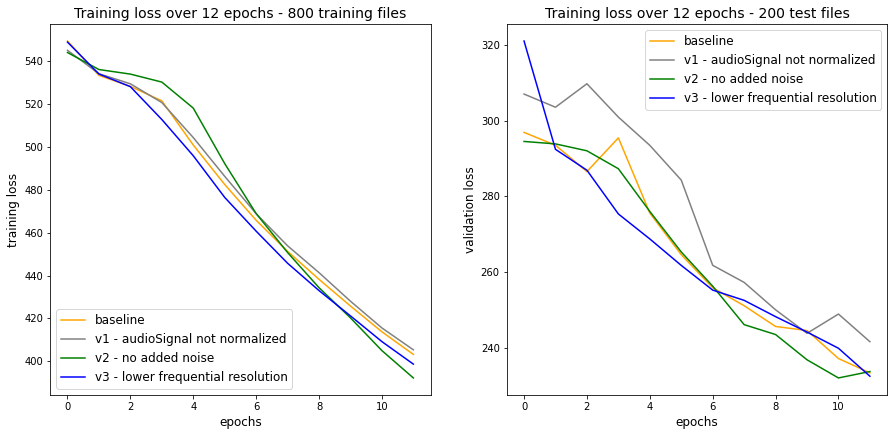

In [16]:
plt.figure(figsize = (15, 15))

plt.subplot(221)
plt.plot(history0.history['loss'], color = 'orange', label = 'baseline')
plt.plot(history1.history['loss'], color = 'grey', label = 'v1 - audioSignal not normalized')
plt.plot(history2.history['loss'], color = 'green', label = 'v2 - no added noise')
plt.plot(history3.history['loss'], color = 'blue', label = 'v3 - lower frequential resolution')

plt.legend(fontsize = 12)
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('training loss', fontsize = 12)
plt.title('Training loss over 12 epochs - 800 training files', fontsize = 14);

plt.subplot(222)
plt.plot(history0.history['val_loss'], color = 'orange', label = 'baseline')
plt.plot(history1.history['val_loss'], color = 'grey', label = 'v1 - audioSignal not normalized')
plt.plot(history2.history['val_loss'], color = 'green', label = 'v2 - no added noise')
plt.plot(history3.history['val_loss'], color = 'blue', label = 'v3 - lower frequential resolution')

plt.legend(fontsize = 12)
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('validation loss', fontsize = 12)
plt.title('Training loss over 12 epochs - 200 test files', fontsize = 14);


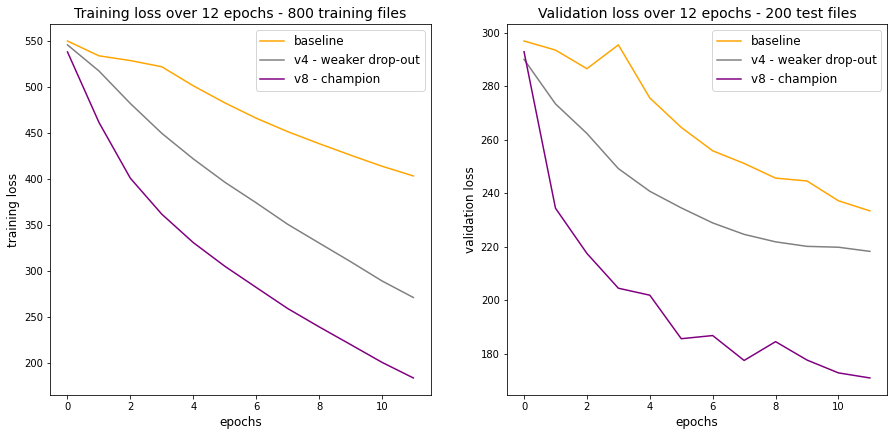

In [12]:
plt.figure(figsize = (15, 15))

plt.subplot(221)
plt.plot(history0.history['loss'], color = 'orange', label = 'baseline')
plt.plot(history4.history['loss'], color = 'grey', label = 'v4 - weaker drop-out')
#plt.plot(history5.history['loss'], color = 'green', label = 'v5 - smaller kernels')
#plt.plot(history6.history['loss'], color = 'blue', label = 'v6 - 3 RNN layers (vs 5)')
#plt.plot(history7.history['loss'], color = 'red', label = 'v7 - 256 RNN per layer (vs 512)')
plt.plot(history8.history['loss'], color = 'purple', label = 'v8 - champion')


plt.legend(fontsize = 12)
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('training loss', fontsize = 12)
plt.title('Training loss over 12 epochs - 800 training files', fontsize = 14);

plt.subplot(222)
plt.plot(history0.history['val_loss'], color = 'orange', label = 'baseline')
plt.plot(history4.history['val_loss'], color = 'grey', label = 'v4 - weaker drop-out')
#plt.plot(history5.history['val_loss'], color = 'green', label = 'v5 - smaller kernels')
#plt.plot(history6.history['val_loss'], color = 'blue', label = 'v6 - 3 RNN layers (vs 5)')
#plt.plot(history7.history['val_loss'], color = 'red', label = 'v7 - 256 RNN per layer (vs 512)')
plt.plot(history8.history['val_loss'], color = 'purple', label = 'v8 - champion')

plt.legend(fontsize = 12)
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('validation loss', fontsize = 12)
plt.title('Validation loss over 12 epochs - 200 test files', fontsize = 14);


Chargement des prédictions sauvegardées

In [33]:
with open(savePath0 + 'predictionHistory', 'rb') as f:
  listPredictions0 = pickle.load(f)
with open(savePath1 + 'predictionHistory', 'rb') as f:
  listPredictions1 = pickle.load(f)
with open(savePath2 + 'predictionHistory', 'rb') as f:
  listPredictions2 = pickle.load(f)
with open(savePath3 + 'predictionHistory', 'rb') as f:
  listPredictions3 = pickle.load(f)
with open(savePath4 + 'predictionHistory', 'rb') as f:
  listPredictions4 = pickle.load(f)
with open(savePath5 + 'predictionHistory', 'rb') as f:
  listPredictions5 = pickle.load(f)
with open(savePath6 + 'predictionHistory', 'rb') as f:
  listPredictions6 = pickle.load(f)
with open(savePath7 + 'predictionHistory', 'rb') as f:
  listPredictions7 = pickle.load(f)
with open(savePath8 + 'predictionHistory', 'rb') as f:
  listPredictions8 = pickle.load(f)


In [40]:
k = 6
epochs = 12
test_size = 200

target = y_test_sample[k]

print('TARGET:')
print('longueur:', len(target), ' étiquette:', target)

print('\nPREDICTIONS')

for epoch in range(epochs):
  prediction = listPredictions8[k + test_size*epoch][0]
  print('EPOCH:', epoch+1, 'longueur:', len(prediction), ' prédiction:', prediction)

TARGET:
longueur: 68  étiquette:  AND THAT TUMBLE'S ENOUGH TO KNOCK THE SENSE OUT OF A FULL GROWN MAN

PREDICTIONS
EPOCH: 1 longueur: 12  prédiction:    S R    R 
EPOCH: 2 longueur: 39  prédiction:  E  TOLASOE MAT NOT THS SA TOL FL ROT M
EPOCH: 3 longueur: 45  prédiction:  IN RA TO WAS OE MET NOT PE SE TOL FOL ROT MA
EPOCH: 4 longueur: 46  prédiction:  N A TO WAS AE MET TO NOT THE SETEL FOL GRO ME
EPOCH: 5 longueur: 48  prédiction:  N ERE TO WAS AE MUT TO NOT THE SETEL FO GRO MAD
EPOCH: 6 longueur: 48  prédiction:  IN RAT TO AF AE MUTO NOT TE SERTE LE FO GRO MEN
EPOCH: 7 longueur: 52  prédiction:  ND HER TO AF AE NUT TO NOT TE SER TEN LEFOL GRO MEN
EPOCH: 8 longueur: 52  prédiction:  AN HA TOL ASF AE MET O NOT HE SIR TEN L FO GROM MAN
EPOCH: 9 longueur: 56  prédiction:  AND HA TOL AT AE NAT TO NOT TE SIT TENT LA FOL GRON MEN
EPOCH: 10 longueur: 56  prédiction:  ND AR TO WAT AE NET TO NOT BE SINT TEN LA FOL GROND MEN
EPOCH: 11 longueur: 53  prédiction:  AND A TOL AS AN NUT TO NOT BE SEN

In [21]:
k = 140
test_size = 200

target = y_test_sample[k]

print('TARGET:')
print('longueur:', len(target), ' étiquette:', target)

print('\nPREDICTIONS')
epoch = 11
prediction0 = listPredictions0[k + test_size*epoch][0]
prediction4 = listPredictions4[k + test_size*epoch][0]
prediction5 = listPredictions5[k + test_size*epoch][0]
prediction6 = listPredictions6[k + test_size*epoch][0]
prediction7 = listPredictions7[k + test_size*epoch][0]
prediction8 = listPredictions8[k + test_size*epoch][0]


print('v0', 'EPOCH:', epoch+1, 'longueur:', len(prediction0), ' prédiction:', prediction0)
print('v4 ', 'EPOCH:', epoch+1, 'longueur:', len(prediction4), ' prédiction:', prediction4)
print('v5 ', 'EPOCH:', epoch+1, 'longueur:', len(prediction5), ' prédiction:', prediction5)
print('v6 ', 'EPOCH:', epoch+1, 'longueur:', len(prediction6), ' prédiction:', prediction6)
print('v7 ', 'EPOCH:', epoch+1, 'longueur:', len(prediction7), ' prédiction:', prediction7)
print('v8 ', 'EPOCH:', epoch+1, 'longueur:', len(prediction8), ' prédiction:', prediction8)

TARGET:
longueur: 59  étiquette:  IF WE HAD BEEN BROTHER AND SISTER INDEED THERE WAS NOTHING

PREDICTIONS
v0 EPOCH: 12 longueur: 43  prédiction:  HLE IN IN POTER EN SESTER IN EE COAS NOTIN
v4  EPOCH: 12 longueur: 51  prédiction:  ITLY HVD IN PROHER AN SISFERT IN KEED FER AS NOHIN
v5  EPOCH: 12 longueur: 46  prédiction:  THEL HD DEM PRSTER AN STERT I EE COL AS NOTIT
v6  EPOCH: 12 longueur: 50  prédiction:  TE LE AN END POSTER IN SESTERR IN HE TE AS NOTHIN
v7  EPOCH: 12 longueur: 40  prédiction:  TL N IN POTR IN SIS TER HN HEN BOWAS OT
v8  EPOCH: 12 longueur: 55  prédiction:  IF WL HAD BEN PROTHER AN SESTER IN KEE THI WAS NOTHING


Evolution de la longueur des prédictions

In [41]:
def getPredictionsLength(listPredictions, testsize = 200, epochs = 12):
  
  length_predictions = []
  for epoch in range(epochs):
    rank = epoch * test_size  
    length_predictions_epoch = [len(listPredictions[k][0]) for k in range(rank, rank + test_size)]   
    length_predictions.append(np.mean(length_predictions_epoch))
  
  return length_predictions


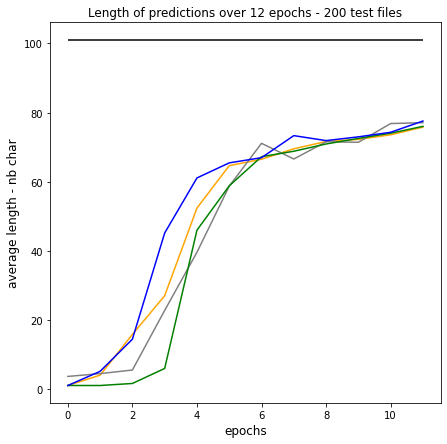

In [96]:
plt.figure(figsize = (7, 7))

referenceLength = np.mean([len(y_test_sample[k]) for k in range(200)])

plt.hlines(y = referenceLength, xmin = 0, xmax = 11, label = 'target length')
plt.plot(getPredictionsLength(listPredictions0), color = 'orange', label = 'baseline')
plt.plot(getPredictionsLength(listPredictions1), color = 'grey', label = 'v1 - audioSignal not normalized')
plt.plot(getPredictionsLength(listPredictions2), color = 'green', label = 'v2 - no added noise')
plt.plot(getPredictionsLength(listPredictions3), color = 'blue', label = 'v3 - lower frequential resolution')
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('average length - nb char', fontsize = 12)
plt.title('Length of predictions over 12 epochs - 200 test files');


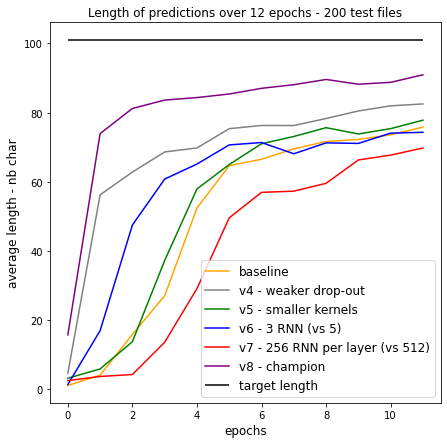

In [23]:
plt.figure(figsize = (7, 7))

referenceLength = np.mean([len(y_test_sample[k]) for k in range(200)])
plt.hlines(y = referenceLength, xmin = 0, xmax = 11, label = 'target length')

plt.plot(getPredictionsLength(listPredictions0), color = 'orange', label = 'baseline')
plt.plot(getPredictionsLength(listPredictions4), color = 'grey', label = 'v4 - weaker drop-out')
plt.plot(getPredictionsLength(listPredictions5), color = 'green', label = 'v5 - smaller kernels')
plt.plot(getPredictionsLength(listPredictions6), color = 'blue', label = 'v6 - 3 RNN (vs 5)')
plt.plot(getPredictionsLength(listPredictions7), color = 'red', label = 'v7 - 256 RNN per layer (vs 512)')
plt.plot(getPredictionsLength(listPredictions8), color = 'purple', label = 'v8 - champion')

plt.legend(fontsize = 12)
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('average length - nb char', fontsize = 12)
plt.title('Length of predictions over 12 epochs - 200 test files');

#plt.plot(getPredictionsLength(listPredictions4))
#plt.plot(getPredictionsLength(listPredictions5))
#plt.plot(getPredictionsLength(listPredictions6))
#plt.plot(getPredictionsLength(listPredictions7))

Evolution du nombre de caractères utilisés

In [24]:
def getCharacters(listPredictions, testsize = 200, epochs = 12):
  
  charList = []
  nbCharList = []
  
#length_predictions = []
 # for epoch in range(epochs):
  #  rank = epoch * test_size  
   # length_predictions_epoch = [len(listPredictions[k][0]) for k in range(rank, rank + test_size)]   
    #length_predictions.append(np.mean(length_predictions_epoch))


  for epoch in range(epochs):
    rank = epoch * test_size
    charList_epoch = []
    predictions_epoch = [listPredictions[k][0] for k in range(rank, rank + test_size)]
    for prediction in predictions_epoch:
      for character in prediction:
        if character not in charList_epoch:
          charList_epoch.append(character)
    charList.append(charList_epoch)
    nbCharList.append(len(charList_epoch))
  
  return (charList, nbCharList)


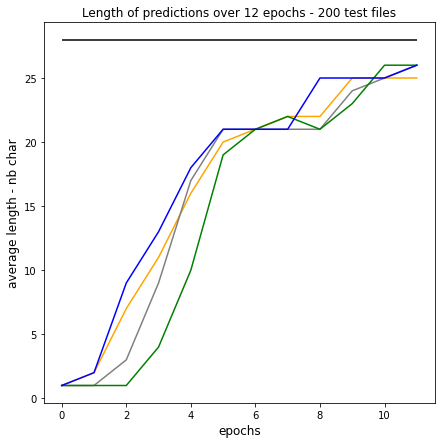

In [113]:
plt.figure(figsize = (7, 7))

referenceNb = 28
plt.hlines(y = referenceNb, xmin = 0, xmax = 11, label = 'total nb of characters')

plt.plot(getCharacters(listPredictions0)[1], color = 'orange', label = 'baseline')
plt.plot(getCharacters(listPredictions1)[1], color = 'grey', label = 'v1 - audioSignal not normalized')
plt.plot(getCharacters(listPredictions2)[1], color = 'green', label = 'v2 - no added noise')
plt.plot(getCharacters(listPredictions3)[1], color = 'blue', label = 'v3 - lower frequential resolution')
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('average length - nb char', fontsize = 12)
plt.title('Length of predictions over 12 epochs - 200 test files');


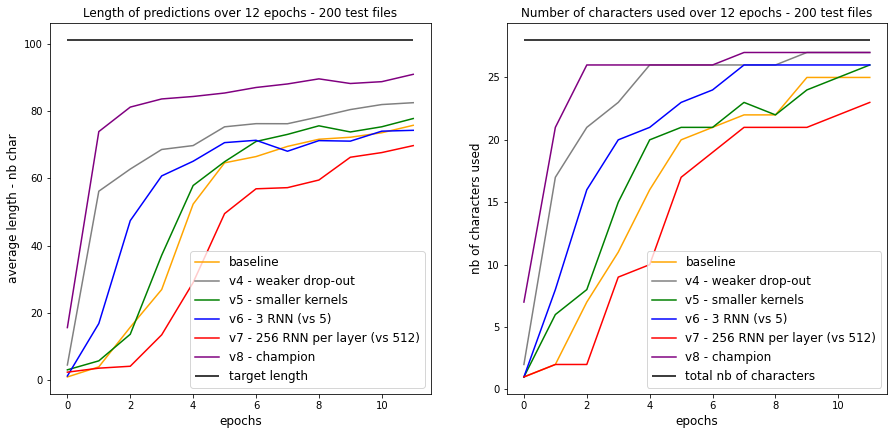

In [25]:
plt.figure(figsize = (15, 15))

plt.subplot(221)

referenceLength = np.mean([len(y_test_sample[k]) for k in range(200)])
plt.hlines(y = referenceLength, xmin = 0, xmax = 11, label = 'target length')

plt.plot(getPredictionsLength(listPredictions0), color = 'orange', label = 'baseline')
plt.plot(getPredictionsLength(listPredictions4), color = 'grey', label = 'v4 - weaker drop-out')
plt.plot(getPredictionsLength(listPredictions5), color = 'green', label = 'v5 - smaller kernels')
plt.plot(getPredictionsLength(listPredictions6), color = 'blue', label = 'v6 - 3 RNN (vs 5)')
plt.plot(getPredictionsLength(listPredictions7), color = 'red', label = 'v7 - 256 RNN per layer (vs 512)')
plt.plot(getPredictionsLength(listPredictions8), color = 'purple', label = 'v8 - champion')

plt.legend(fontsize = 12)
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('average length - nb char', fontsize = 12)
plt.title('Length of predictions over 12 epochs - 200 test files');

plt.subplot(222)

referenceNb = 28
plt.hlines(y = referenceNb, xmin = 0, xmax = 11, label = 'total nb of characters')

plt.plot(getCharacters(listPredictions0)[1], color = 'orange', label = 'baseline')
plt.plot(getCharacters(listPredictions4)[1], color = 'grey', label = 'v4 - weaker drop-out')
plt.plot(getCharacters(listPredictions5)[1], color = 'green', label = 'v5 - smaller kernels')
plt.plot(getCharacters(listPredictions6)[1], color = 'blue', label = 'v6 - 3 RNN (vs 5)')
plt.plot(getCharacters(listPredictions7)[1], color = 'red', label = 'v7 - 256 RNN per layer (vs 512)')
plt.plot(getCharacters(listPredictions8)[1], color = 'purple', label = 'v8 - champion')

plt.legend(fontsize = 12)
plt.xlabel('epochs', fontsize = 12)
plt.ylabel('nb of characters used', fontsize = 12)
plt.title('Number of characters used over 12 epochs - 200 test files');
